# Promedio RMS de $Ro = \left|\frac{\zeta}{f}\right|$ en función del tiempo

In [1]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import gif
import imageio
import seaborn as sns
import numpy as np
from scipy import signal
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import date,datetime,timedelta
sns.set()
sns.set_style("ticks")

In [3]:
from spectral_analysis.common_vars.directories import OUT_IMGS_FOLDER
from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.regions import ids_regions,lats4id,faces_regions
from spectral_analysis.luigi_workflows.output import uv4idt,UV4id,VorticityGrid
import spectral_analysis.tools.gif as gif

In [4]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S")
logging.getLogger().setLevel(logging.INFO)

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True

In [11]:
%%script false
def getBathymetry(area_box):
    logging.info("Bathymetry for box {}".format(area_box)_
    min_lon,max_lon,min_lat,max_lat = area_box
    mask_lonlat_f = np.where((LON_>=min_lon) & (LON_<=max_lon) & (LAT_>=min_lat) & (LAT_<=max_lat))
    faces = set(mask_lonlat_f[0])
    logging.debug("faces {}".format(faces))
    LON_area = [None]*len(faces)
    LAT_area = [None]*len(faces)
    DEPTH_area = [None]*len(faces)
    for i,face in enumerate(faces):
        LON_f = LON_[face,:,:]
        LAT_f = LAT_[face,:,:]
        mask_lonlat = np.where((LON_f>=min_lon) & (LON_f<=max_lon) & (LAT_f>=min_lat) & (LAT_f<=max_lat))
        min_i,max_i = min(mask_lonlat[0]),max(mask_lonlat[0])
        min_j,max_j = min(mask_lonlat[1]),max(mask_lonlat[1])
        logging.debug("{},{},{},{},{}".format(face,min_i,max_i,min_j,max_j))
        LON_area[i] = LON_f[min_i:max_i,min_j:max_j]
        LAT_area[i] = LAT_f[min_i:max_i,min_j:max_j]
        DEPTH_area[i] = DEPTH_[face,min_i:max_i,min_j:max_j]
    return LON_area,LAT_area,DEPTH_area

In [12]:
%%script false
def plotBathymetry(area_box):
    LON,LAT,DEPTH = getBathymetry(area_box)
    logging.info("depth len: {}".format(len(DEPTH)))
    for i in range(len(DEPTH)):
        LON_f = LON[i]
        LAT_f = LAT[i]
        DEPTH_f = DEPTH[i]
        logging.debug("Shapes (lon,lat,depth) {},{},{}".format(LON_f.shape,LAT_f.shape,DEPTH_f.shape))
        #plt.pcolormesh(LON_f,LAT_f,DEPTH_f,cmap=plt.cm.Pastel1,norm=norm_bath)
        cs = plt.contour(LON_f,LAT_f,DEPTH_f,levels=[0,200,1000],cmap=plt.cm.Greys_r,extend="max",zorder=0)
        plt.clabel(cs, inline=True, fontsize='large',fmt="%d")

In [5]:
margin = 6
firstday = datetime(2012,1,1)

def plot_ro_region_t(current,t_idx,t_vec,t_res="days",norm=False,absolute=False,baroclinic=False):
	rv_range = 1 if norm else 0.8
	rv_type = "Normalized " if norm else ""
	o_fmt = "" if norm else " $[10^{-4} s^{-1}]$"
	dt_days = 1 if t_res=="days" else 24
	divnorm_ro = colors.DivergingNorm(vmin=-rv_range, vcenter=0, vmax=rv_range)
	
	#fig, ax = plt.subplots(1,2,figsize=(20,10))
	fig = plt.figure(figsize=(10,10))
	#ax = ax.flat[:]
	t_ = t_vec[t_idx]
	t__ = t_ - idx_t[t_res]["JFM"][0]
	t_delta = timedelta(hours=t__) if t_res=="hours" else timedelta(days=t__)
	t_label = (firstday + t_delta).date()
	#t_label = [t__-idx_t[t_res]["JFM"][0]+1 for t__ in t_vec]
	logging.debug("{}/{}".format(t_idx+1,len(t_vec)))
	lon_min,lat_min,lon_max,lat_max = (180,90,-180,-90)

	for r_id in ids_regions[current]:
		#Ro_vec = Ro_dict[r_id]
		logging.debug("U,V for {} ({})".format(r_id,t_res))
		U0,V0 = uv4idt(r_id,t_,0,t_res)
		grid = VorticityGrid(r_id)
		if baroclinic:
			UH,VH = uv4idt(r_id,t_,36,t_res)
			RV = grid.rv(U0,V0)-grid.rv(UH,VH)
		else:
			RV = grid.rv(U0,V0)
		norm_rv = grid.f if norm else 1e-4
		rv_sum = grid.f if absolute else 0
		Ro = (RV+rv_sum)/norm_rv
		LON,LAT = grid.xyg()
		lon_min = min(lon_min,np.min(LON))
		lat_min = min(lat_min,np.min(LAT))
		lon_max = max(lon_max,np.max(LON))
		lat_max = max(lat_max,np.max(LAT))
		#plt.sca(ax[0])
		plt.pcolormesh(LON,LAT,Ro,norm=divnorm_ro,cmap=plt.cm.RdBu,zorder=10)
		#plt.sca(ax[1])
		#plt.plot(t_label,Ro_vec,label="{0:d} @ {1:0.1f},{2:0.1f}".format(r_id,np.mean(LON),np.mean(LAT)))
	#plt.sca(ax[0])
	plt.colorbar()
	box = (lon_min,lon_max+margin,lat_min,lat_max)
	#plotBathymetry(box)
	plt.xlabel("Longitude",fontsize='large')
	plt.ylabel("Latitude",fontsize='large')
	plt.title(t_label,fontsize='x-large')
	#plt.sca(ax[1])
	#plt.xlim([t_label[0],t_label[-1]])
	#plt.xlabel("Year{}".format(t_res),fontsize='large')
	#plt.ylabel("RMS(Ro)",fontsize='large')
	#plt.title("RMS(Ro) by region - {}".format(current),fontsize='x-large')
	#plt.legend()
	plt.axis("equal")

	fig.suptitle("{}Relative Vorticity{}".format(rv_type,o_fmt),fontsize='xx-large')
	return fig#,ax

In [ ]:
t_r = "days"
fps = 3 if t_r == "days" else 6
for current,ids in ids_regions.items():
	if current=="California":
		for season in ["ASO","JFM"]:
			times = idx_t[t_r][season]
			n_times = len(times)
			#o_d = {r_id:[None]*n_times for r_id in ids}
			logging.debug("{},{}".format(current,season))
			fname_gif = '{}/rms_ro_all_{}_{}.gif'.format(OUT_IMGS_FOLDER,current,season)
			Path(fname_gif).parent.mkdir(parents=True, exist_ok=True)
			logging.debug("Saving {} ...".format(fname_gif))
			frames = (plot_ro_region_t(current,idx_t,times,t_r,norm=False,absolute=False) for idx_t in range(n_times))
			gif.save(frames, fname_gif, duration=1000/fps) # Duration in ms
			logging.info("Saved! {}".format(fname_gif))
		gc.collect()

## Graficando RMS(Ro)

In [6]:
def getRoRms(r_id,season,t_res="days",norm=False,absolute=False,baroclinic=False):
	t = idx_t[t_res][season]
	U0,V0 = UV4id(r_id,t,0,t_res=t_res,t_firstaxis=True)
	grid = VorticityGrid(r_id)
	norm_rv = grid.f if norm else 1e-4
	sum_rv = grid.f if absolute else 0
	if baroclinic:
		UH,VH = UV4id(r_id,t,36,t_res=t_res,t_firstaxis=True)
		RV = grid.rv(U0,V0)-grid.rv(UH,VH)
	else:
		RV = grid.rv(U0,V0)
	Ro = (RV+sum_rv)/norm_rv
	#return np.sqrt(np.mean(Ro**2,axis=(1,2)))
	return np.std(Ro,axis=(1,2))

In [7]:
prop_cycle = plt.rcParams['axes.prop_cycle']

def roRmsByCurrent(current,season,t_res="days",norm=True,absolute=False,baroclinic=False):
	times = np.array(idx_t[t_res][season])
	n_times = len(times)
	n_ids = len(ids_regions[current])
	allRoRms = [getRoRms(r_id,season,t_res,norm,absolute,baroclinic) for r_id in ids_regions[current]]
	colors = prop_cycle.by_key()['color']
	var = "Ro" if norm else "RV"
	o_fmt = "" if norm else "\n$[10^{-4} s^{-1}]$"
	
	if t_res=="days":
		f_ticks_lab = [2,7,15,21,30,40]
		day_dt = 1
	else:
		f_ticks_lab = [h/24 for h in [6,12,24,7*24,15*24,30*24]]
		day_dt = 24
		
	t_label = [(t__-idx_t[t_res]["JFM"][0]+1)/day_dt for t__ in times]
	f = np.fft.rfftfreq(n_times,1) # T=1 {t_days}: intervalo de muestreo
		
	f_ticks = [1/(24*D) for D in f_ticks_lab]
	fig = plt.figure(figsize=(12,8),constrained_layout=True)
	gs = fig.add_gridspec(n_ids,2)
	
	axT = []
	axF = []
	maxY_t = 0
	minY_t = 1
	maxY_f = 0
	for i,r_id,ro_rms in zip(range(n_ids),ids_regions[current],allRoRms):
		lat = lats4id[r_id]
		lbl = "{0} @ {1:0.1f}".format(r_id,lat)
		color = colors[i]
		logging.debug("color {}".format(color))
		# Time domain
		ax0 = fig.add_subplot(gs[i,0])
		axT.append(ax0)
		plt.sca(ax0)
		maxY_t = max(maxY_t,np.max(ro_rms))
		minY_t = min(minY_t,np.min(ro_rms))
		plt.plot(t_label,ro_rms,label=lbl,color=color)
		plt.ylabel("Std({}){}".format(var,o_fmt),size="x-large")
		# Frequency domain
		ax1 = fig.add_subplot(gs[i,1])
		axF.append(ax1)
		plt.sca(ax1)
		#ro_rms = signal.detrend(ro_rms,type='linear')
		rorms_f = np.abs(np.fft.rfft(ro_rms))
		maxY_f = max(maxY_f,np.max(rorms_f))
		plt.loglog(f,rorms_f,label=r_id,color=color)
		plt.xticks(ticks=f_ticks,labels=f_ticks_lab,size="large")
		logging.debug("{},{},{},{}".format(r_id,minY_t,maxY_t,maxY_f))
		if i==n_ids-1:
			ax0.set_xlabel("Yeardays",size="x-large")
			ax1.set_xlabel("Period in days",size="x-large")
		if i==0:
			ax0.set_title("Time domain\n"+lbl)
			ax1.set_title("FFT \n"+lbl)
		else:
			ax0.set_title(lbl)
			ax1.set_title(lbl)
	plt.suptitle("{} / {}".format(current,season),size="xx-large")
	for axt,axf in zip(axT,axF):
		axt.set_ylim([minY_t,maxY_t])
		axf.set_ylim([1e-1,maxY_f])
	plt.show()	#print("Box",box)

2020-06-04 18:01:33 INFO     California,JFM
2020-06-04 18:01:33 INFO     UV shape (k=0): (290, 289, 2184)
2020-06-04 18:03:09 INFO     UV shape (k=0): (288, 287, 2184)
2020-06-04 18:04:44 INFO     UV shape (k=0): (290, 287, 2184)
2020-06-04 18:06:21 INFO     UV shape (k=0): (288, 287, 2184)
2020-06-04 18:07:57 INFO     UV shape (k=0): (291, 289, 2184)
2020-06-04 18:09:34 INFO     UV shape (k=0): (288, 289, 2184)


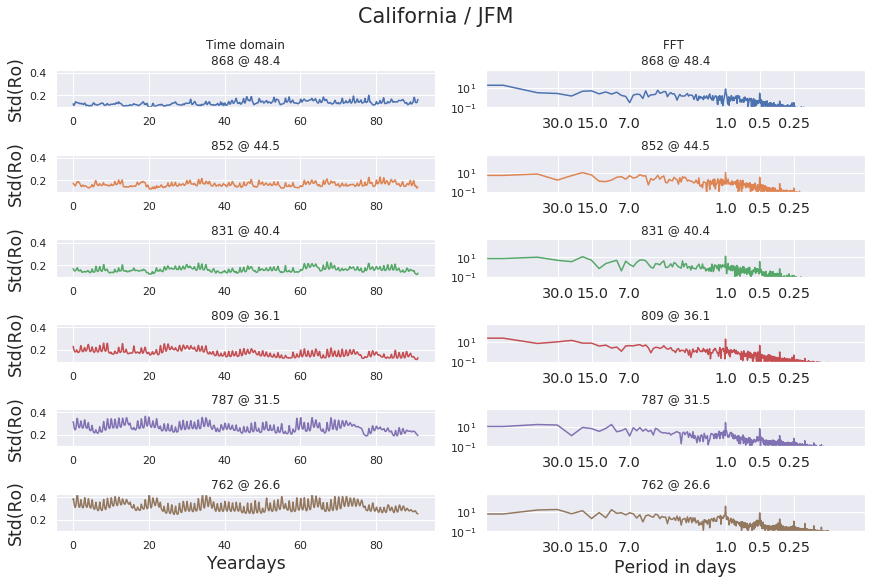

2020-06-04 18:11:22 INFO     California,ASO
2020-06-04 18:11:23 INFO     UV shape (k=0): (290, 289, 2208)
2020-06-04 18:12:53 INFO     UV shape (k=0): (288, 287, 2208)
2020-06-04 18:14:18 INFO     UV shape (k=0): (290, 287, 2208)
2020-06-04 18:15:46 INFO     UV shape (k=0): (288, 287, 2208)
2020-06-04 18:17:14 INFO     UV shape (k=0): (291, 289, 2208)
2020-06-04 18:18:41 INFO     UV shape (k=0): (288, 289, 2208)


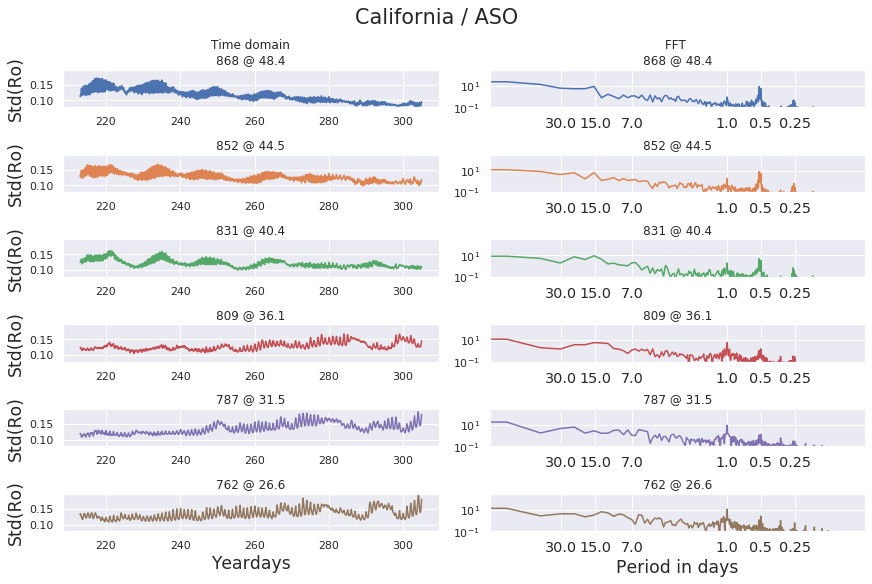

2020-06-04 18:20:16 INFO     Canarias,JFM
2020-06-04 18:20:16 INFO     UV shape (k=0): (291, 289, 2184)
2020-06-04 18:21:37 INFO     UV shape (k=0): (288, 289, 2184)
2020-06-04 18:22:28 INFO     UV shape (k=0): (290, 289, 2184)
2020-06-04 18:23:51 INFO     UV shape (k=0): (288, 289, 2184)


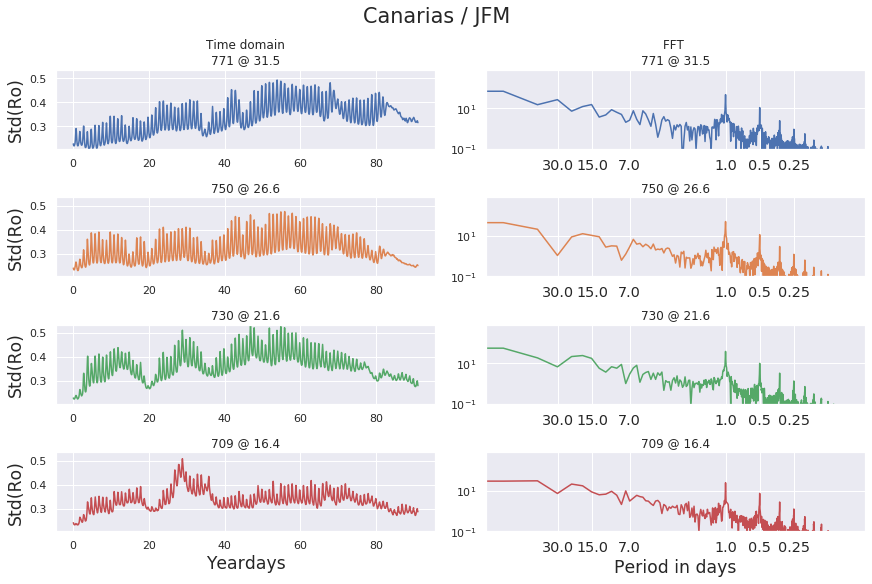

2020-06-04 18:25:18 INFO     Canarias,ASO
2020-06-04 18:25:18 INFO     UV shape (k=0): (291, 289, 2208)
2020-06-04 18:26:45 INFO     UV shape (k=0): (288, 289, 2208)
2020-06-04 18:27:33 INFO     UV shape (k=0): (290, 289, 2208)
2020-06-04 18:29:05 INFO     UV shape (k=0): (288, 289, 2208)


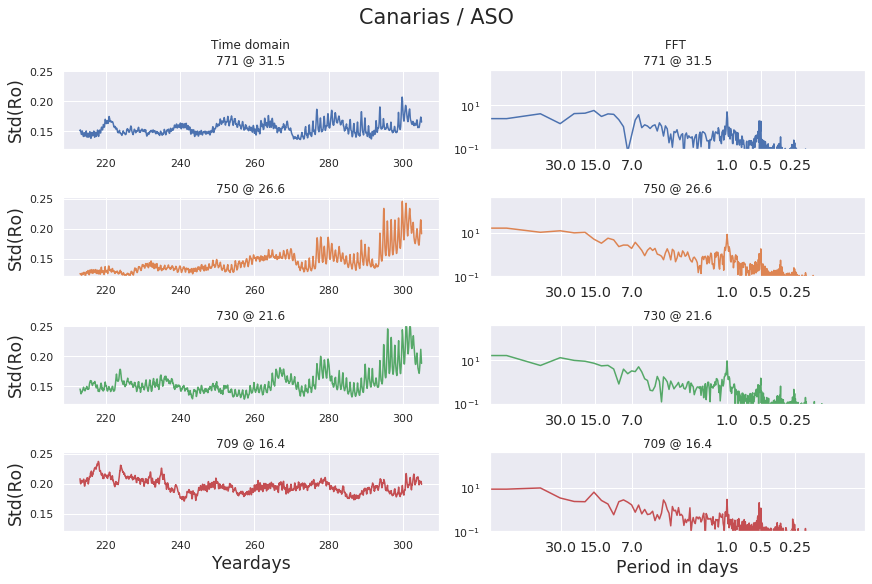

2020-06-04 18:30:42 INFO     Peru,JFM
2020-06-04 18:30:42 INFO     UV shape (k=0): (288, 289, 2184)
2020-06-04 18:32:06 INFO     UV shape (k=0): (290, 289, 2184)
2020-06-04 18:33:33 INFO     UV shape (k=0): (290, 289, 2184)


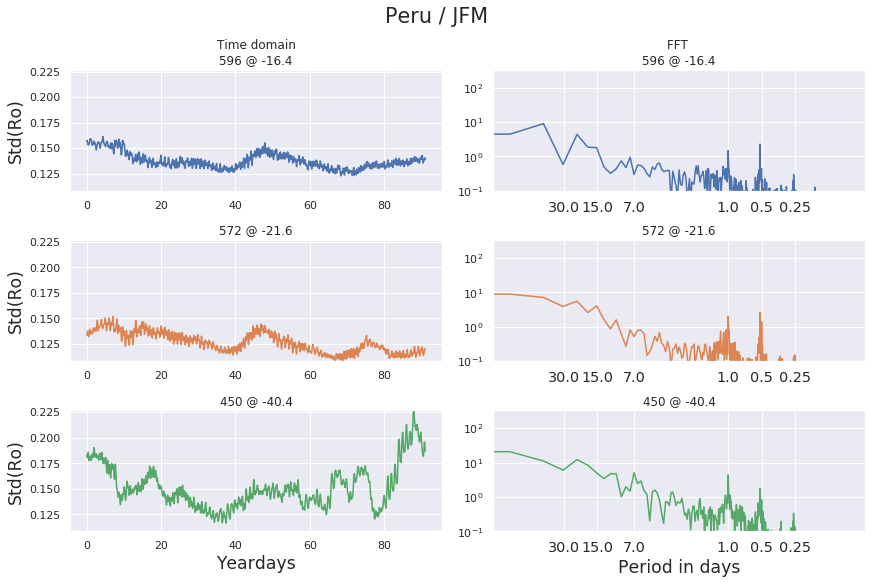

2020-06-04 18:35:06 INFO     Peru,ASO
2020-06-04 18:35:06 INFO     UV shape (k=0): (288, 289, 2208)
2020-06-04 18:36:33 INFO     UV shape (k=0): (290, 289, 2208)
2020-06-04 18:38:10 INFO     UV shape (k=0): (290, 289, 2208)


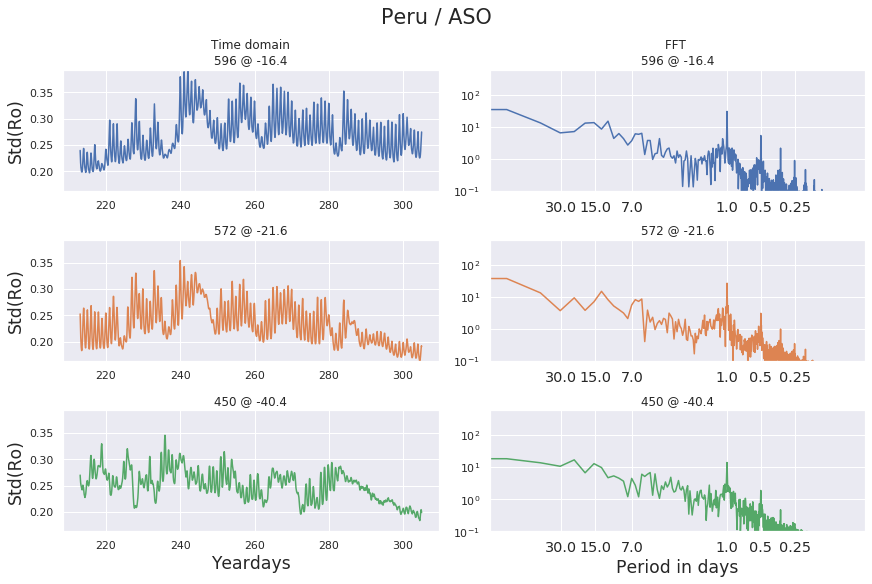

2020-06-04 18:40:13 INFO     Benguela,JFM
2020-06-04 18:40:13 INFO     UV shape (k=0): (290, 289, 2184)
2020-06-04 18:41:51 INFO     UV shape (k=0): (288, 289, 2184)
2020-06-04 18:43:30 INFO     UV shape (k=0): (288, 289, 2184)


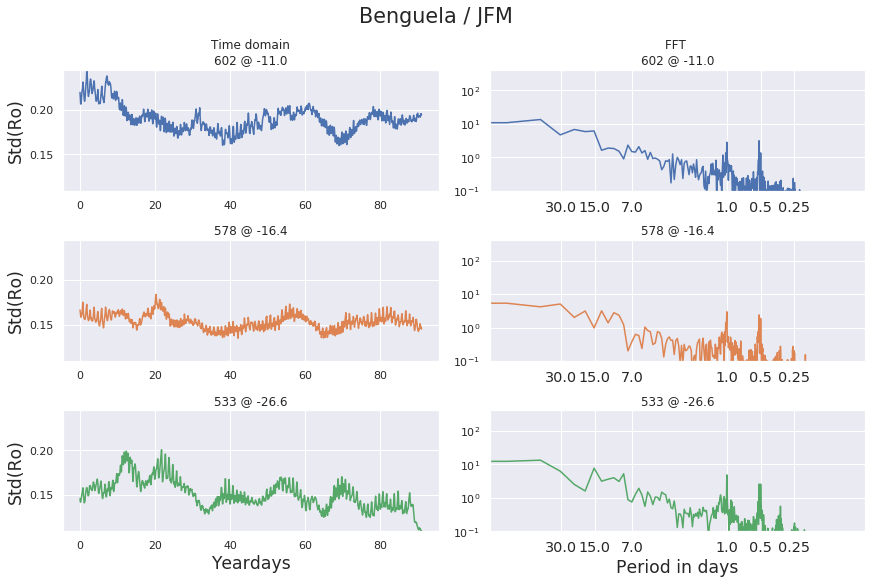

2020-06-04 18:45:13 INFO     Benguela,ASO
2020-06-04 18:45:13 INFO     UV shape (k=0): (290, 289, 2208)
2020-06-04 18:46:58 INFO     UV shape (k=0): (288, 289, 2208)
2020-06-04 18:48:42 INFO     UV shape (k=0): (288, 289, 2208)


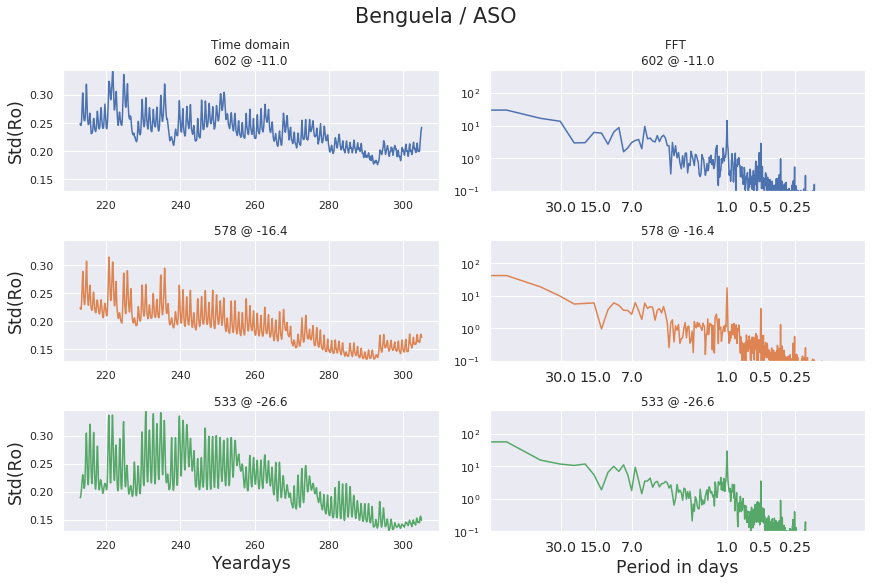

2020-06-04 18:50:12 INFO     Kuroshio,JFM
2020-06-04 18:50:12 INFO     UV shape (k=0): (288, 289, 2184)
2020-06-04 18:51:34 INFO     UV shape (k=0): (288, 289, 2184)
2020-06-04 18:53:03 INFO     UV shape (k=0): (290, 289, 2184)


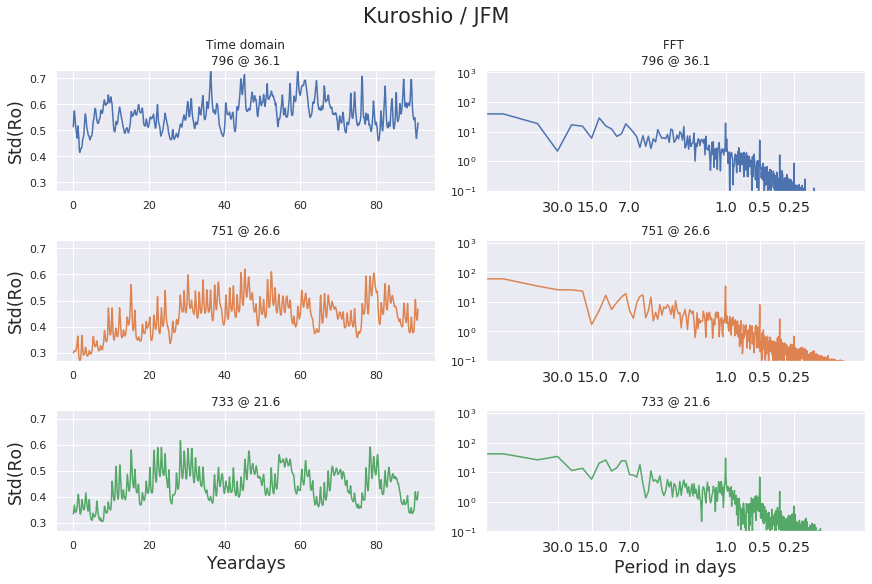

2020-06-04 18:54:34 INFO     Kuroshio,ASO
2020-06-04 18:54:34 INFO     UV shape (k=0): (288, 289, 2208)
2020-06-04 18:56:05 INFO     UV shape (k=0): (288, 289, 2208)
2020-06-04 18:57:36 INFO     UV shape (k=0): (290, 289, 2208)


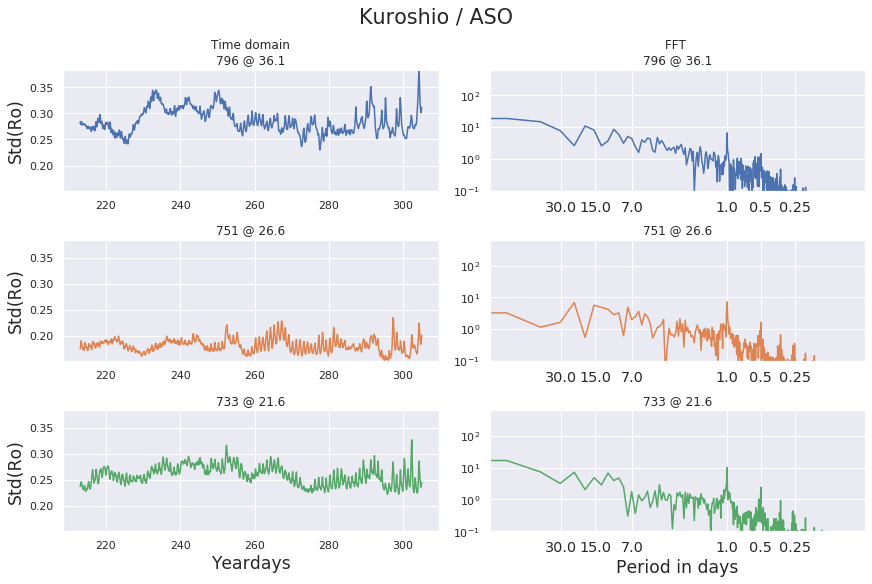

In [9]:
for current,season in product(ids_regions.keys(),["JFM","ASO"]):
	logging.info("{},{}".format(current,season))
	roRmsByCurrent(current,season,"hours")

### Probando cálculo de correlaciones temporales entre RV y DIV

In [21]:
current,t_res,season = "Canarias","hours","ASO"
rid = ids_regions[current][1]
t = idx_t[t_res][season]
grid = VorticityGrid(rid)
U_,V_ = UV4id(rid,t,0,t_res=t_res,t_firstaxis=True)

2020-06-04 23:43:47 INFO     UV shape (k=0): (288, 289, 2208)


In [22]:
Ro_ = grid.rv(U_,V_)/grid.f
Delta_ = grid.div(U_,V_)/grid.f

In [25]:
stdRo = np.std(Ro_,axis=(1,2))
stdDelta = np.std(Delta_,axis=(1,2))

In [48]:
stdRo_det = signal.detrend(stdRo)
stdDelta_det = signal.detrend(stdDelta)

In [56]:
stdRo_f = np.fft.fftshift(np.fft.fft(stdRo))
stdDelta_f = np.fft.fftshift(np.fft.fft(stdDelta))
stdRo_fr = np.fft.rfft(stdRo)
stdDelta_fr = np.fft.rfft(stdDelta)

In [58]:
print(np.corrcoef(stdRo,stdDelta))
print(np.corrcoef(stdRo_det,stdDelta_det))

[[1.        0.0805918]
 [0.0805918 1.       ]]
[[1.        0.0477859]
 [0.0477859 1.       ]]


In [50]:
ff = np.fft.fftshift(np.fft.fftfreq(U_.shape[0],1)) # T=1 {t_res}: intervalo de muestreo
ffr = np.fft.rfftfreq(U_.shape[0],1) # T=1 {t_res}: intervalo de muestreo

In [66]:
f_ticks_lab = [h/24 for h in [6,12,24,7*24,15*24,30*24]]
f_ticks = [1/(24*D) for D in f_ticks_lab]
f_ticks_all = f_ticks+[-1*tick for tick in f_ticks]
f_ticks_lab_all = f_ticks_lab+[-1*tick for tick in f_ticks_lab]

In [74]:
corr_f = stdRo_f*np.conj(stdDelta_f)

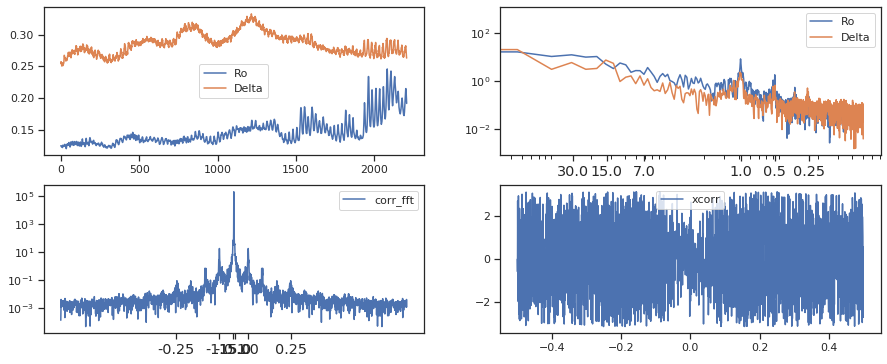

In [73]:
fig, ax = plt.subplots(2,2,figsize=(15,6))
ax = ax.flat[:]

plt.sca(ax[0])
plt.plot(stdRo)
plt.plot(stdDelta)
plt.legend(["Ro","Delta"])
plt.sca(ax[1])
plt.loglog(ffr,np.abs(stdRo_fr))
plt.loglog(ffr,np.abs(stdDelta_fr))
plt.xticks(ticks=f_ticks,labels=f_ticks_lab,size="large")
plt.legend(["Ro","Delta"])
plt.sca(ax[2])
plt.semilogy(ff,np.abs(corr_f))
plt.xticks(ticks=f_ticks_all[::2],labels=f_ticks_lab_all[::2],size="large")
plt.legend(["corr_fft"])
plt.sca(ax[3])
plt.plot(ff,np.angle(corr_f))
plt.legend(["xcorr"])
plt.show()

### * Extra: Creando animación de RV y DIV para una región cualquiera

In [8]:
# GIF decorator: See https://github.com/maxhumber/gif#usage
@gif.frame
def pcolormesh_(rv,lon,lat,name="RV",norm=True,dpi=100):
	std = np.std(rv)
	range_ = 1 if norm else 1e-4
	divnorm_rv = colors.DivergingNorm(vmin=-1*range_, vcenter=0, vmax=1*range_)
	fig = plt.figure(figsize=(12,10),dpi=dpi)
	plt.pcolormesh(lon,lat,rv,norm=divnorm_rv,cmap=plt.cm.RdBu)
	plt.colorbar()
	plt.title("std({0})={1:0.3f}".format(name,std),size="xx-large")
	plt.gca().set_aspect('equal', adjustable='box')
	#return fig

def animsave_uvfun(fun,r_id,season,uv_surf,uv_int=None,name="RV",t_res="hours",norm=True,absolute=False):
	gc.collect()
	name = name.upper()
	mode = "b" if uv_int else ""
	norm_rv = grid.f if norm else 1e-4
	sum_rv = grid.f if (absolute and name=="RV") else 0
	fps = 3 if t_res=="days" else 24
	t = idx_t[t_res][season]
	#
	logging.info("Calculating {}{}...".format(name,mode))
	U0,V0 = uv_surf
	F = fun(U0,V0)
	if name=="OW": #Does a baroclinic Okubo-Weiss number make sense?
		norm_rv = norm_rv**2 # OW uses strain and RV squared, so F (if normalized) should be as well
	elif uv_int: # DIV and RV could be calculated as baroclinic, as we compare bottom vs surface
		UH,VH = uv_int
		F = F-fun(UH,VH)
	F = (F+sum_rv)/norm_rv
	# Converting
	nt,_,_ = U0.shape
	LON,LAT = grid.xyg()
	fname_gif = '{}/{}{}_{}_{}.gif'.format(OUT_IMGS_FOLDER,name,mode,r_id,season)
	Path(fname_gif).parent.mkdir(parents=True, exist_ok=True)
	logging.info("Generating frames...")
	frames = (pcolormesh_(F[i,:,:],LON,LAT,name,norm) for i in range(nt))
	logging.info("Saving {} ...".format(fname_gif))
	gif.save(frames, fname_gif, duration=1000/fps) # Duration in ms
	logging.info("Saved! {}".format(fname_gif))
	del frames
	gc.collect()

In [22]:
r_id = 787
t_res = "hours"
season = "ASO"

In [26]:
grid = VorticityGrid(r_id)
t = idx_t[t_res][season]
uv0 = UV4id(r_id,t,0,t_res=t_res,t_firstaxis=True)
uvh = UV4id(r_id,t,36,t_res=t_res,t_firstaxis=True)

2020-05-26 01:00:28 INFO     UV shape (k=36): (291, 289, 2208)


In [27]:
animsave_uvfun(grid.rv,r_id,season,uv0,uvh,name="RV")

2020-05-26 01:02:01 INFO     Calculating RVb...
2020-05-26 01:02:36 INFO     Generating frames...
2020-05-26 01:02:36 INFO     Saving /home/antonio/GoogleDrive/Tesis/data/output_images/RVb_787_ASO.gif ...
2020-05-26 01:14:56 INFO     Saved! /home/antonio/GoogleDrive/Tesis/data/output_images/RVb_787_ASO.gif


In [ ]:
animsave_uvfun(grid.div,r_id,season,uv0,uvh,name="DIV")

2020-05-26 01:15:13 INFO     Calculating DIVb...
2020-05-26 01:15:39 INFO     Generating frames...
2020-05-26 01:15:39 INFO     Saving /home/antonio/GoogleDrive/Tesis/data/output_images/DIVb_787_ASO.gif ...


In [ ]:
animsave_uvfun(grid.ow,r_id,season,uv0,uvh,name="OW")

### Comprobando DIV y RV

In [ ]:
from xmitgcm import open_mdsdataset

In [4]:
from spectral_analysis.common_vars.directories import MODEL_FOLDER,DATA_FOLDER
grid_path = "{}/LLC4320/grid/".format(MODEL_FOLDER)

In [5]:
grid10 = open_mdsdataset(grid_path, read_grid=True, iters=None, default_dtype=np.float32, geometry="llc").isel(face=10)

In [6]:
grid10

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
    face     int64 10
    XC       (j, i) >f4 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) >f4 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XG       (j_g, i_g) >f4 dask.array<chunksize=(4320, 4320), meta=np.nd

In [7]:
LONc = grid10.XC.values
LATc = grid10.YC.values
DXc = grid10.dxC.values
DYc = grid10.dyC.values
rAc = grid10.rA.values

In [8]:
LONg = grid10.XG.values
LATg = grid10.YG.values
DXg = grid10.dxG.values
DYg = grid10.dyG.values
rAz = grid10.rAz.values

In [9]:
unorm = colors.DivergingNorm(vmin=-2, vcenter=0, vmax=2)
ucmap = plt.cm.RdBu_r

In [10]:
min_i,min_j,max_i,max_j = 288,862,577,1153

In [13]:
uu,vv = uv4idt(0,200,0,"days")

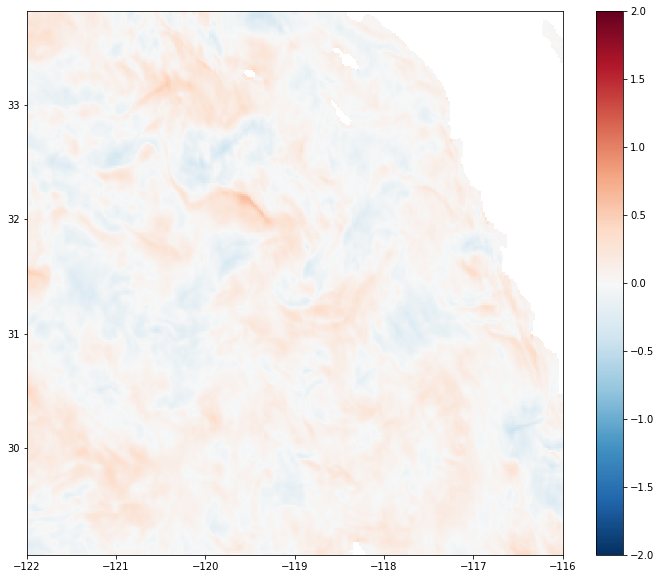

In [14]:
plt.figure(figsize=(12,10))
plt.pcolormesh(np.rot90(LONg)[min_j:max_j,min_i:max_i],np.rot90(LATg)[min_j:max_j,min_i:max_i],uu,norm=unorm,cmap=ucmap)
plt.colorbar()
plt.show()

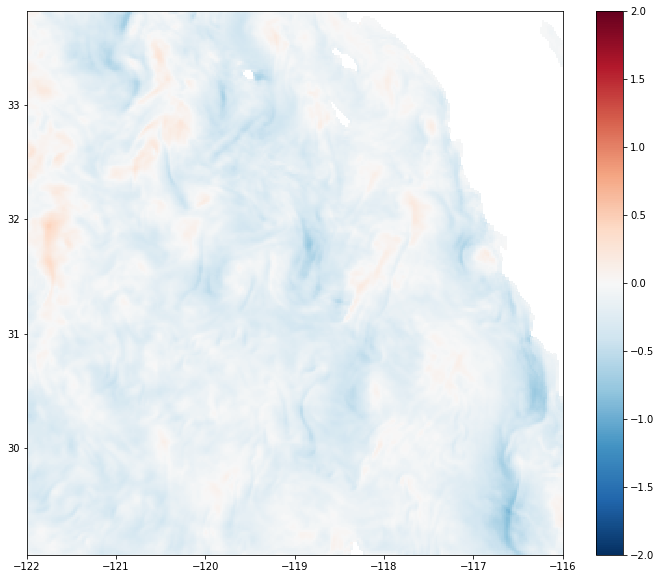

In [15]:
plt.figure(figsize=(12,10))
plt.pcolormesh(np.rot90(LONg)[min_j:max_j,min_i:max_i],np.rot90(LATg)[min_j:max_j,min_i:max_i],vv,norm=unorm,cmap=ucmap)
plt.colorbar()
plt.show()

In [17]:
nn=3

In [18]:
long = np.rot90(LONg)[min_j:max_j:nn,min_i:max_i:nn]
latg = np.rot90(LATg)[min_j:max_j:nn,min_i:max_i:nn]
lonc = np.rot90(LONc)[min_j:max_j,min_i:max_i]
latc = np.rot90(LATc)[min_j:max_j,min_i:max_i]
dyc = np.rot90(DYc)[min_j:max_j,min_i:max_i]
dxc = np.rot90(DXc)[min_j:max_j,min_i:max_i]
dyg = np.rot90(DYg)[min_j:max_j,min_i:max_i]
dxg = np.rot90(DXg)[min_j:max_j,min_i:max_i]
raz = np.rot90(rAz)[min_j:max_j,min_i:max_i]
rac = np.rot90(rAc)[min_j:max_j,min_i:max_i]

In [20]:
ur,vr = vv,-uu

In [19]:
rv = (np.gradient(dyc*vv,axis=-1,edge_order=2) - np.gradient(dxc*uu,axis=-2,edge_order=2))/raz
div = (np.gradient(dyg*uu,axis=-1,edge_order=2) + np.gradient(dxg*vv,axis=-2,edge_order=2))/rac

In [20]:
norm_rv = colors.DivergingNorm(vmin=-1e-4, vcenter=0, vmax=1e-4)

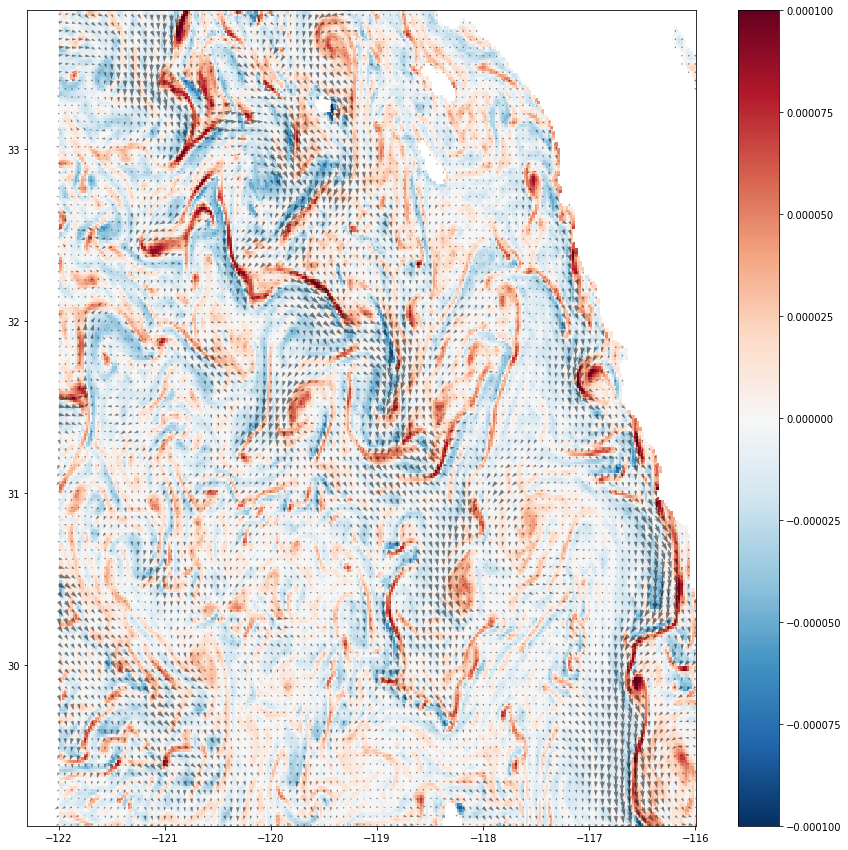

In [21]:
plt.figure(figsize=(15,15))
plt.quiver(long,latg,uu[::nn,::nn],vv[::nn,::nn],zorder=10,alpha=0.5)
plt.pcolormesh(lonc,latc,rv,norm=norm_rv,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.show()

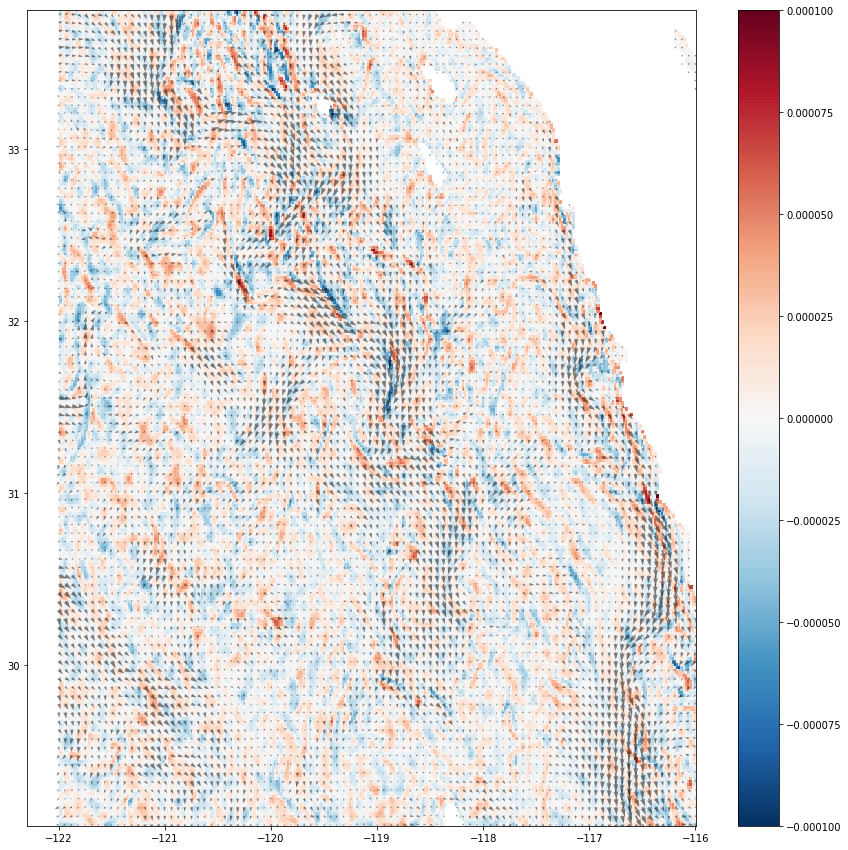

In [22]:
plt.figure(figsize=(15,15))
plt.quiver(long,latg,uu[::nn,::nn],vv[::nn,::nn],zorder=10,alpha=0.5)
plt.pcolormesh(lonc,latc,div,norm=norm_rv,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.show()